In [1]:
import pandas as pd
import sys
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt

# Precinct Shapefile

## VEST's Documentation File

Election results from New Hampshire Secretary of State (https://sos.nh.gov/2016GenResults.aspx)

Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release.

The Census VTD shapefile includes wards for the Town of Berlin and the Town of Derry that are only used for municipal elections. These were merged to match the statewide election returns. The wards for the Town of Laconia were revised to match the 2012 municipal redistricting map.

Results reported across two files, one for the general, one for the presidential primary.

*nh_2016_pres_primary file*
- P16PREDCLI - Hillary Clinton
- P16PREDSAN - Bernie Sanders
- P16PREDOMA - Martin O'Malley
- P16PREDOTH - Other Candidates on Ballot


- P16PRERTRU - Donald Trump
- P16PRERKAS - John Kasich
- P16PRERCRU - Ted Cruz
- P16PRERBUS - Jeb Bush
- P16PRERRUB - Marco Rubio
- P16PRERCHR - Chris Christie
- P16PRERFIO - Carly Fiorina
- P16PRERCAR - Ben Carson
- P16PRERPAU - Rand Paul
- P16PREROTH - Other Candidates on Ballot


## Load VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/nh_2016_pres_primary/nh_2016_pres_primary.shp")

In [3]:
vest_shp.shape

(321, 20)

In [4]:
vest_shp.head(1)

,STATEFP,COUNTYFP,VTDST,NAMELSAD,NAME,P16PREDCLI,P16PREDSAN,P16PREDOMA,P16PREDOTH,P16PRERTRU,P16PRERKAS,P16PRERCRU,P16PRERBUS,P16PRERRUB,P16PRERCHR,P16PRERFIO,P16PRERCAR,P16PRERPAU,P16PREROTH,geometry
0,33,001,ALTO01,TOWN OF ALTON,ALTON,241,490,3,4,681,233,305,188,186,123,65,54,5,5,"POLYGON Z ((-71.34362 43.62879 0.00000, -71.34..."


<AxesSubplot:>

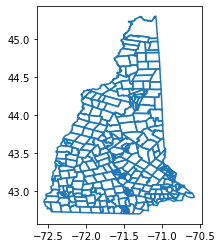

In [5]:
vest_shp.boundary.plot()

# Loading, Combining Election Results

## Load County Fips File

In [6]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="New Hampshire"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Presidential GOP Results

Made president-republican-edited.xls by removing header rows and merging rows that weren't merged in the excel file. 

In [7]:
pres_gop = pd.ExcelFile('./raw-from-source/SOS/presidential-primary/president-republican-edited.xls')

excel_tabs = {x + ' R':x for x in fips_dict.keys()}

df_list = []
for tab in excel_tabs: 
    df = pd.read_excel(pres_gop, tab)
    df = df.set_index('Candidate').T
    df.replace(' ','',inplace=True)
    df.replace('',0,inplace=True)
    for c in [x for x in df.columns.to_list() if ', ' in x]:
        df[c] = df[c].astype(float)
        df[c] = df[c].fillna(0)
        df[c] = df[c].astype(int)
    df.rename(columns = {'Trump, r':'P16PRERTRU','Kasich, r':'P16PRERKAS','Cruz, r':'P16PRERCRU',
                         'Bush, r':'P16PRERBUS','Rubio, r':'P16PRERRUB','Christie, r':'P16PRERCHR',
                         'Fiorina, r':'P16PRERFIO','Carson, r':'P16PRERCAR','Paul, r':'P16PRERPAU'}, inplace = True)
    other_cols = [c for c in df.columns.to_list() if 'P16' not in c]
    df['P16PREROTH'] = df[other_cols].sum(axis=1)
    df.reset_index(inplace=True)
    df.drop(columns = other_cols, inplace = True)
    df.rename(columns={'index':'Precinct'},inplace=True)
    df.rename_axis(None, axis=1, inplace=True)
    df['County'] = excel_tabs[tab]
    df_list.append(df)
pres_gop = pd.concat(df_list, axis = 0, ignore_index = True)
pres_gop = pres_gop[(pres_gop['Precinct'] != '') & (pres_gop['Precinct'] != 'TOTALS')]
pres_gop.head()

,Precinct,P16PRERBUS,P16PRERCAR,P16PRERCHR,P16PRERCRU,P16PRERFIO,P16PRERKAS,P16PRERPAU,P16PRERRUB,P16PRERTRU,P16PREROTH,County
0,Alton,188,54,123,305,65,233,5,186,681,5,Belknap
1,Barnstead,114,29,67,198,41,122,4,84,421,4,Belknap
2,Belmont,157,59,72,198,61,204,7,148,654,10,Belknap
3,Center Harbor,32,8,25,40,19,75,2,38,111,6,Belknap
4,Gilford,264,33,135,205,93,440,9,220,719,6,Belknap


## Presidential Dem Results

Made president-democratic-edited.xls by removing header rows and merging rows that weren't merged in the excel file. 

In [8]:
pres_dem = pd.ExcelFile('./raw-from-source/SOS/presidential-primary/president-democratic-edited.xls')

excel_tabs = {x + ' D':x for x in fips_dict.keys()}

df_list = []
for tab in excel_tabs: 
    df = pd.read_excel(pres_dem, tab)
    df = df.set_index('Candidate').T
    df.replace(' ','',inplace=True)
    df.replace('',0,inplace=True)
    for c in [x for x in df.columns.to_list() if ', ' in x]:
        df[c] = df[c].astype(float)
        df[c] = df[c].fillna(0)
        df[c] = df[c].astype(int)
    df.rename(columns = {'Clinton, d':'P16PREDCLI','Sanders, d':'P16PREDSAN',"O'Malley, d":'P16PREDOMA'}, inplace = True)
    other_cols = [c for c in df.columns.to_list() if 'P16' not in c]
    df['P16PREDOTH'] = df[other_cols].sum(axis=1)
    df.reset_index(inplace=True)
    df.drop(columns = other_cols, inplace = True)
    df.rename(columns={'index':'Precinct'},inplace=True)
    df.rename_axis(None, axis=1, inplace=True)
    df['County'] = excel_tabs[tab]
    df_list.append(df)
pres_dem = pd.concat(df_list, axis = 0, ignore_index = True)
pres_dem = pres_dem[(pres_dem['Precinct'] != '') & (pres_dem['Precinct'] != 'TOTALS')]
pres_dem.head()

,Precinct,P16PREDCLI,P16PREDOMA,P16PREDSAN,P16PREDOTH,County
0,Alton,241,3,490,4,Belknap
1,Barnstead,206,1,518,4,Belknap
2,Belmont,313,5,653,6,Belknap
3,Center Harbor,79,0,128,0,Belknap
4,Gilford,521,9,692,8,Belknap


## Combine Results

In [9]:
print(pres_gop.shape, pres_dem.shape)
pres_gop['Precinct'] = pres_gop['Precinct'].str.strip()
pres_dem['Precinct'] = pres_dem['Precinct'].str.strip()

pres_gop.Precinct = pres_gop.Precinct.replace('\s+', ' ', regex=True)
pres_dem.Precinct = pres_dem.Precinct.replace('\s+', ' ', regex=True)

pres_gop['Precinct'] = pres_gop['Precinct'].str.replace('-','')
pres_dem['Precinct'] = pres_dem['Precinct'].str.replace('-','')

pres_gop['Precinct'] = pres_gop['Precinct'].str.replace('*','',regex=True)
pres_dem['Precinct'] = pres_dem['Precinct'].str.replace('*','',regex=True)

(320, 12) (320, 6)


In [10]:
election_results = pres_gop.merge(pres_dem, how = 'outer', on = ['County','Precinct'], indicator = True)
display(election_results.shape)
display(election_results[election_results['_merge'] != 'both'][['County','Precinct','_merge']].sort_values(['County','Precinct']))

(322, 17)

,County,Precinct,_merge
68,Coos,Chandler's Pur,left_only
320,Coos,Chandler's Purchase,right_only
321,Coos,Second Coll. Gt.,right_only
96,Coos,Second College Gt.,left_only


In [11]:
pres_dem.loc[pres_dem.Precinct == "Chandler's Purchase", "Precinct"] = "Chandler's Pur"
pres_dem.loc[pres_dem.Precinct == 'Second Coll. Gt.', "Precinct"] = "Second College Gt."

In [12]:
election_results.drop(columns = ['_merge'], inplace = True)
election_results = pres_gop.merge(pres_dem, how = 'outer', on = ['County','Precinct'], indicator = True)
display(election_results.shape)
display(election_results[election_results['_merge'] != 'both'][['County','Precinct','_merge']].sort_values(['County','Precinct']))

(320, 17)

,County,Precinct,_merge


# Validating Election Results

## Race Totals

In [13]:
vest_shp.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAMELSAD', 'NAME', 'P16PREDCLI',
       'P16PREDSAN', 'P16PREDOMA', 'P16PREDOTH', 'P16PRERTRU', 'P16PRERKAS',
       'P16PRERCRU', 'P16PRERBUS', 'P16PRERRUB', 'P16PRERCHR', 'P16PRERFIO',
       'P16PRERCAR', 'P16PRERPAU', 'P16PREROTH', 'geometry'],
      dtype='object')

In [14]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))


data_columns = ['P16PREDCLI',
       'P16PREDSAN', 'P16PREDOMA', 'P16PREDOTH', 'P16PRERTRU', 'P16PRERKAS',
       'P16PRERCRU', 'P16PRERBUS', 'P16PRERRUB', 'P16PRERCHR', 'P16PRERFIO',
       'P16PRERCAR', 'P16PRERPAU', 'P16PREROTH']

statewide_totals_check(vest_shp, election_results, data_columns)

***Statewide Totals Check***
P16PREDCLI is equal 	VEST / RDH: 95355
P16PREDSAN is equal 	VEST / RDH: 152193
P16PREDOMA is equal 	VEST / RDH: 667
P16PREDOTH is equal 	VEST / RDH: 1372
P16PRERTRU is equal 	VEST / RDH: 100735
P16PRERKAS is equal 	VEST / RDH: 44932
P16PRERCRU is equal 	VEST / RDH: 33244
P16PRERBUS is equal 	VEST / RDH: 31341
P16PRERRUB is equal 	VEST / RDH: 30071
P16PRERCHR is equal 	VEST / RDH: 21089
P16PRERFIO is equal 	VEST / RDH: 11774
P16PRERCAR is equal 	VEST / RDH: 6527
P16PRERPAU is equal 	VEST / RDH: 1930
P16PREROTH is equal 	VEST / RDH: 1331


## County-by-County Totals

In [15]:
fips_dict

{'Belknap': '001',
 'Carroll': '003',
 'Cheshire': '005',
 'Coos': '007',
 'Grafton': '009',
 'Hillsborough': '011',
 'Merrimack': '013',
 'Rockingham': '015',
 'Strafford': '017',
 'Sullivan': '019'}

In [16]:
election_results['COUNTYFP'] = election_results['County'].map(fips_dict)

In [17]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

               
county_totals_check(vest_shp,election_results,data_columns,'COUNTYFP')

***Countywide Totals Check***

P16PREDCLI is equal across all counties
P16PREDSAN is equal across all counties
P16PREDOMA is equal across all counties
P16PREDOTH is equal across all counties
P16PRERTRU contains differences in these counties:
	009 has a difference of 20564 votes
		VEST: 25461 votes
		SOURCES: 4897 votes
	011 has a difference of -20564 votes
		VEST: 8764 votes
		SOURCES: 29328 votes
P16PRERKAS contains differences in these counties:
	009 has a difference of 7850 votes
		VEST: 11325 votes
		SOURCES: 3475 votes
	011 has a difference of -7850 votes
		VEST: 4667 votes
		SOURCES: 12517 votes
P16PRERCRU contains differences in these counties:
	009 has a difference of 6554 votes
		VEST: 8280 votes
		SOURCES: 1726 votes
	011 has a difference of -6554 votes
		VEST: 3052 votes
		SOURCES: 9606 votes
P16PRERBUS contains differences in these counties:
	009 has a difference of 6756 votes
		VEST: 8620 votes
		SOURCES: 1864 votes
	011 has a difference of -6756 votes
		VEST: 2828 votes
	

Summary results to compare to: https://sos.nh.gov/media/w22hzzaq/summary-president-republican16pp.pdf

It looks like VEST swapped counties 009 (Grafton) and 011 (Hillsborough) in the Republican primary. 

## Precinct-by-Precinct Votes

### Merge VEST and RDH

#### Clean

In [18]:
display(election_results.sort_values('COUNTYFP').head(2))
display(vest_shp.sort_values('COUNTYFP').head(2))

,Precinct,P16PRERBUS,P16PRERCAR,P16PRERCHR,P16PRERCRU,P16PRERFIO,P16PRERKAS,P16PRERPAU,P16PRERRUB,P16PRERTRU,P16PREROTH,County,P16PREDCLI,P16PREDOMA,P16PREDSAN,P16PREDOTH,_merge,COUNTYFP
0,Alton,188,54,123,305,65,233,5,186,681,5,Belknap,241,3,490,4,both,001
15,Tilton,69,17,45,112,33,87,4,58,280,6,Belknap,233,3,359,5,both,001


,STATEFP,COUNTYFP,VTDST,NAMELSAD,NAME,P16PREDCLI,P16PREDSAN,P16PREDOMA,P16PREDOTH,P16PRERTRU,P16PRERKAS,P16PRERCRU,P16PRERBUS,P16PRERRUB,P16PRERCHR,P16PRERFIO,P16PRERCAR,P16PRERPAU,P16PREROTH,geometry
0,33,001,ALTO01,TOWN OF ALTON,ALTON,241,490,3,4,681,233,305,188,186,123,65,54,5,5,"POLYGON Z ((-71.34362 43.62879 0.00000, -71.34..."
318,33,001,LACO03,LACONIA WARD 3,LACONIA WARD 3,202,244,0,2,140,115,68,77,65,47,27,13,3,3,"POLYGON Z ((-71.51071 43.54764 0.00000, -71.51..."


In [19]:
len(vest_shp['NAME'].unique())

321

In [20]:
len(election_results['Precinct'].unique())

320

In [21]:
vest_shp['join_col'] = vest_shp['COUNTYFP'] + vest_shp['NAME'].str.replace('TOWN OF ','').str.replace('TOWNSHIP OF ','').str.lower()
election_results['join_col'] = election_results['COUNTYFP'] + election_results['Precinct'].str.replace("'","").str.lower()

In [22]:
election_results.join_col = election_results.join_col.replace('\s+', ' ', regex=True)
election_results.join_col = election_results.join_col.str.strip()

In [23]:
election_results.drop(columns = ['_merge'], inplace = True)

#### Join Attempt #1

In [24]:
merge_df = vest_shp.merge(election_results, how = 'outer', on = 'join_col', indicator = True)
merge_df[merge_df['_merge'] != 'both'][['join_col','County']]

,join_col,County
19,003hales location,NaN
21,003harts location,NaN
57,007atkinson and gilmanton academy grant,NaN
58,007beans grant,NaN
59,007beans purchase,NaN
63,007chandlers purchase,NaN
66,007crawfords purchase,NaN
68,007dixs grant,NaN
72,007cutts grant,NaN
75,007ervings location,NaN


In [25]:
election_results['join_col'] = election_results['join_col'].str.replace('.',' ',regex=False)

election_results['join_col'] = election_results['join_col'].str.replace(' gt',' grant',regex=False)
election_results['join_col'] = election_results['join_col'].str.replace(' loc',' location',regex=False)
election_results['join_col'] = election_results['join_col'].str.replace(' pur',' purchase',regex=False)

#### Join Attempt #2

In [26]:
merge_df.drop(columns = ['_merge'], inplace=True)
merge_df = vest_shp.merge(election_results, how = 'outer', on = 'join_col', indicator = True)
merge_df[merge_df['_merge'] != 'both'][['join_col','County']]

,join_col,County
19,003hales location,NaN
21,003harts location,NaN
57,007atkinson and gilmanton academy grant,NaN
66,007crawfords purchase,NaN
68,007dixs grant,NaN
75,007ervings location,NaN
76,007hadleys purchase,NaN
78,007greens grant,NaN
81,007low and burbanks grant,NaN
82,007martins location,NaN


In [27]:
merge_df[merge_df['_merge'] == 'left_only']['join_col'].sort_values().unique()

array(['003hales location', '003harts location',
       '007atkinson and gilmanton academy grant', '007berlin wards 1-3',
       '007crawfords purchase', '007dixs grant', '007ervings location',
       '007greens grant', '007hadleys purchase',
       '007low and burbanks grant', '007martins location',
       '007pinkhams grant', '007sargents purchase',
       '007second college grant', '007thompson and meserves purchase',
       '007wentworth location', '015derry wards 1-4', '015not defined'],
      dtype=object)

In [28]:
merge_df[merge_df['_merge'] == 'right_only']['join_col'].sort_values().unique()

array(['003hales location ', '003harts location ',
       '007at  & gil  ac  grant', '007berlin', '007crawfords purchase ',
       '007dixs grant ', '007ervings location ', '007greens grant ',
       '007hadleys purchase ', '007low & burbanks grant',
       '007martins location ', '007pinkhams grant ',
       '007sargents purchase ', '007second college grant ',
       '007thompson & mess purchase ', '007wentworths location',
       '015derry'], dtype=object)

In [29]:
name_changes = {'003hales location ':'003hales location', '003harts location ':'003harts location',
       '007at  & gil  ac  grant': '007atkinson and gilmanton academy grant', 
       '007berlin':'007berlin wards 1-3', '007crawfords purchase ':'007crawfords purchase',
       '007dixs grant ':'007dixs grant', '007ervings location ':'007ervings location', '007greens grant ':'007greens grant',
       '007hadleys purchase ':'007hadleys purchase', '007low & burbanks grant':'007low and burbanks grant',
       '007martins location ':'007martins location', '007pinkhams grant ': '007pinkhams grant',
       '007sargents purchase ':'007sargents purchase', '007second college grant ':'007second college grant',
       '007thompson & mess purchase ':'007thompson and meserves purchase', '007wentworths location':'007wentworth location',
       '015derry':'015derry wards 1-4'}

In [30]:
for k in name_changes: 
    election_results.loc[election_results['join_col'] == k, 'join_col'] = name_changes[k]

#### Join Attempt #3

In [31]:
merge_df.drop(columns = ['_merge'], inplace=True)
merge_df = vest_shp.merge(election_results, how = 'outer', on = 'join_col', indicator = True)
merge_df[merge_df['_merge'] != 'both'][['join_col','County']]

,join_col,County
268,015not defined,NaN


In [32]:
vest_shp[vest_shp['join_col'] == '015not defined']

,STATEFP,COUNTYFP,VTDST,NAMELSAD,NAME,P16PREDCLI,P16PREDSAN,P16PREDOMA,P16PREDOTH,P16PRERTRU,...,P16PRERCRU,P16PRERBUS,P16PRERRUB,P16PRERCHR,P16PRERFIO,P16PRERCAR,P16PRERPAU,P16PREROTH,geometry,join_col
268,33,015,ZZZZZZ,not defined,not defined,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"MULTIPOLYGON Z (((-70.69464 42.95636 0.00000, ...",015not defined


### Validate

In [33]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [34]:
# Replace nan votes with 0 votes
for col in data_columns: 
    merge_df[col + '_y'] = merge_df[col + '_y'].fillna(0)


precinct_votes_check(merge_df,data_columns,True,'join_col',print_level=0)

P16PRERTRU ...........................................................009alexandria (V) ..925  (S)..194 (D):  731
P16PRERKAS ...........................................................009alexandria (V) ..865  (S)...63 (D):  802
P16PRERCRU ...........................................................009alexandria (V) ..379  (S)...49 (D):  330
P16PRERBUS ...........................................................009alexandria (V) ..403  (S)...35 (D):  368
P16PRERRUB ...........................................................009alexandria (V) ..407  (S)...25 (D):  382
P16PRERCHR ...........................................................009alexandria (V) ..351  (S)...11 (D):  340
P16PRERFIO ...........................................................009alexandria (V) ..167  (S)...36 (D):  131
P16PRERCAR ...........................................................009alexandria (V) ...45  (S)...10 (D):   35
P16PRERPAU ...........................................................009alexandria (V) 